# Neural IBM1 - T2

Neural IBM 1 with additional French context (Section 2.1 of the notebook)

In [3]:
# first run a few imports:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from pprint import pprint
import pickle
from utils import smart_reader, bitext_reader
from vocabulary import OrderedCounter, Vocabulary 
from utils import iterate_minibatches, prepare_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [10]:
# the paths to our training and validation data, English side
train_e_path = 'data/training/hansards.36.2.e.gz'
train_f_path = 'data/training/hansards.36.2.f.gz'
dev_e_path = 'data/validation/dev.e.gz'
dev_f_path = 'data/validation/dev.f.gz'
dev_wa = 'data/validation/dev.wa.nonullalign'
test_e_path = 'data/test/test.e.gz'
test_f_path = 'data/test/test.f.gz'
test_wa = 'data/test/test.wa.nonullalign'

These are the vocabularies that we use further on.

In [5]:
# Using only 1000 words will result in many UNKs, but
# it will make training a lot faster. 
# If you have a fast computer, a GPU, or a lot of time,
# try with 10000 instead.
max_tokens=1000

corpus_e = smart_reader(train_e_path)    
vocabulary_e = Vocabulary(corpus=corpus_e, max_tokens=max_tokens)
pickle.dump(vocabulary_e, open("vocabulary_e.pkl", mode="wb"))

corpus_f = smart_reader(train_f_path)    
vocabulary_f = Vocabulary(corpus=corpus_f, max_tokens=max_tokens)
pickle.dump(vocabulary_f, open("vocabulary_f.pkl", mode="wb"))

### Building our model

We import the NeuralIBM1Model from T2.py and NeuralIBM1Trainer from T2trainer.py

In [37]:
from T2 import NeuralIBM1Model
from T2trainer import NeuralIBM1Trainer

Now we instantiate a model and start training.

In [38]:
tf.reset_default_graph()



with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=10  # on CPU, use something much smaller e.g. 1-16
    max_length=30
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=5, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess,
        max_num=1000) # small training corpus just to make testing new code easier

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())


    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_likelihoods, dev_likelihoods = results

Training with B=10 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Epoch 1 loss 56.032799 accuracy 0.23 val_aer 0.89 val_acc 0.19
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Epoch 2 loss 50.121376 accuracy 0.24 val_aer 0.85 val_acc 0.19
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Epoch 3 loss 49.377529 accuracy 0.24 val_aer 0.83 val_acc 0.19
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Epoch 4 loss 48.939950 accuracy 0.24 val_aer 0.80 val_acc 0.19
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Epoch 5 loss 48.017672 accuracy 0.24 val_aer 0.77 val_acc 0.19
Computing dev-set likelihood
Model saved in file: model.ckpt


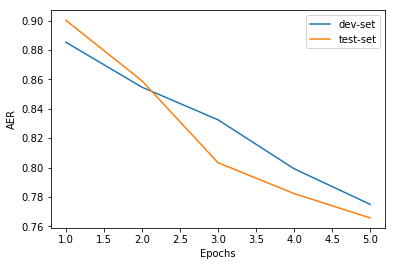

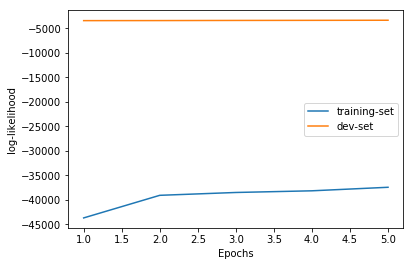

In [40]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()


handles = []
ax1 = plt.plot(range(1, len(train_likelihoods)+1), train_likelihoods, label='training-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(dev_likelihoods)+1), dev_likelihoods, label='dev-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()

